In [1]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc

import pickle
from keras.callbacks import ModelCheckpoint
#from cfg import Config

### Memory/Gpu error without this for some reason, find out why later
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
###

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:08:00.0, compute capability: 7.5



In [2]:
os.chdir('..')

In [3]:
len([x for x in range(0,77)])//50

1

In [4]:
MAIN_PATH = 'Processed/RAVDESSspeech/'

In [5]:
def check_data():
    if os.path.isfile(config.p_path):
        print('Loading existing data for {} model'.format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [6]:
def build_rand_feat():
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        # Get random class
        rand_class = np.random.choice(class_dist.index, p=prob_dist)
        # Grab a file belonging to the random class
        file = np.random.choice(df[df.Emotion==rand_class].index)
        rate, wav = wavfile.read(MAIN_PATH + 'clean/' + file)
        label = df.at[file, 'Emotion']
        # Start to grab a random 10 millisecond interval from the file
        rand_index = np.random.randint(0, wav.shape[0] - config.step)
        sample = wav[rand_index:rand_index + config.step]
        # Get MFCC
        X_sample = mfcc(sample, rate, 
                        numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
        # Update _min and _max
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        
        X.append(X_sample)
        y.append(classes.index(label)) # label is an integer (index posistion of label)
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y)
    # Normalize X to rescale between 0 and 1
    X = (X - _min) / (_max - _min)
    
    #FOR TESTING
    pre_reshapeX = X
    #####
    
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    # For recurrent network
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
        
    # Because of the cost function for the neural network (categorical crossentropi?) we
    #one hot encode integer labels to a matrix
    y = to_categorical(y, num_classes=len(classes))
    
    config.data = (X, y)
    with open(config.p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return X, y

In [7]:
#Moved to cfg.py
class Config:
    def __init__(self, data_save_path=MAIN_PATH, mode='conv', nfilt=26, 
                 nfeat=13, nfft=512, rate=16000, step_seconds=0.4):
        self.rate = rate
        self.nfft = nfft
        self.nfeat = nfeat
        self.nfilt = nfilt
        self.mode = mode
        self.step = int(rate*step_seconds) # 
        # newer lines
        self.model_path = os.path.join(MAIN_PATH, mode + '.model')
        self.p_path = os.path.join(MAIN_PATH, mode + '.p')

In [8]:
df = pd.read_csv(MAIN_PATH + 'ravdessSpeech.csv')
df.set_index('Filename', inplace=True)

In [9]:
df

,FilePath,Modality,VocalChannel,Emotion,EmotionalIntensity,Statement,Repitition,Actor,Gender
Filename,,,,,,,,,
03-01-01-01-01-02-05.wav,Datasets/Audio_Speech_Actors_01-24/Actor_05/03...,3,1,Neutral,1,1,2,5,Male
03-01-04-02-02-01-05.wav,Datasets/Audio_Speech_Actors_01-24/Actor_05/03...,3,1,Sad,2,2,1,5,Male
03-01-04-01-01-02-05.wav,Datasets/Audio_Speech_Actors_01-24/Actor_05/03...,3,1,Sad,1,1,2,5,Male
03-01-03-02-01-02-05.wav,Datasets/Audio_Speech_Actors_01-24/Actor_05/03...,3,1,Happy,2,1,2,5,Male
03-01-04-02-01-01-05.wav,Datasets/Audio_Speech_Actors_01-24/Actor_05/03...,3,1,Sad,2,1,1,5,Male
...,...,...,...,...,...,...,...,...,...
03-01-06-02-02-01-04.wav,Datasets/Audio_Speech_Actors_01-24/Actor_04/03...,3,1,Fearful,2,2,1,4,Female
03-01-01-01-02-02-04.wav,Datasets/Audio_Speech_Actors_01-24/Actor_04/03...,3,1,Neutral,1,2,2,4,Female
03-01-06-01-02-02-04.wav,Datasets/Audio_Speech_Actors_01-24/Actor_04/03...,3,1,Fearful,1,2,2,4,Female


Add length to panda frame. length in seconds

In [10]:
for f in df.index:
    rate, signal = wavfile.read(MAIN_PATH + 'clean/' + f)
    df.at[f, 'length'] = signal.shape[0]/rate

In [11]:
df

,FilePath,Modality,VocalChannel,Emotion,EmotionalIntensity,Statement,Repitition,Actor,Gender,length
Filename,,,,,,,,,,
03-01-01-01-01-02-05.wav,Datasets/Audio_Speech_Actors_01-24/Actor_05/03...,3,1,Neutral,1,1,2,5,Male,1.597625
03-01-04-02-02-01-05.wav,Datasets/Audio_Speech_Actors_01-24/Actor_05/03...,3,1,Sad,2,2,1,5,Male,1.174125
03-01-04-01-01-02-05.wav,Datasets/Audio_Speech_Actors_01-24/Actor_05/03...,3,1,Sad,1,1,2,5,Male,1.417625
03-01-03-02-01-02-05.wav,Datasets/Audio_Speech_Actors_01-24/Actor_05/03...,3,1,Happy,2,1,2,5,Male,2.074375
03-01-04-02-01-01-05.wav,Datasets/Audio_Speech_Actors_01-24/Actor_05/03...,3,1,Sad,2,1,1,5,Male,1.447750
...,...,...,...,...,...,...,...,...,...,...
03-01-06-02-02-01-04.wav,Datasets/Audio_Speech_Actors_01-24/Actor_04/03...,3,1,Fearful,2,2,1,4,Female,1.756000
03-01-01-01-02-02-04.wav,Datasets/Audio_Speech_Actors_01-24/Actor_04/03...,3,1,Neutral,1,2,2,4,Female,1.241750
03-01-06-01-02-02-04.wav,Datasets/Audio_Speech_Actors_01-24/Actor_04/03...,3,1,Fearful,1,2,2,4,Female,1.496375


Show class distribution

In [12]:
classes = list(np.unique(df.Emotion))
class_dist = df.groupby(['Emotion'])['length'].mean()

In [13]:
classes

['Angry', 'Calm', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']

In [14]:
len(classes)

8

In [15]:
class_dist

Emotion
Angry        2.098734
Calm         1.796068
Disgust      2.032028
Fearful      1.954391
Happy        1.847820
Neutral      1.549719
Sad          1.790979
Surprised    1.623700
Name: length, dtype: float64

In [16]:
n_samples = int(df['length'].sum()/0.1)
n_samples

26723

probability distribution so that sum is equal to 1

In [17]:
prob_dist = class_dist/class_dist.sum()

In [18]:
prob_dist

Emotion
Angry        0.142835
Calm         0.122236
Disgust      0.138295
Fearful      0.133011
Happy        0.125758
Neutral      0.105470
Sad          0.121890
Surprised    0.110505
Name: length, dtype: float64

In [19]:
choices = np.random.choice(class_dist.index, p=prob_dist)
choices

'Disgust'

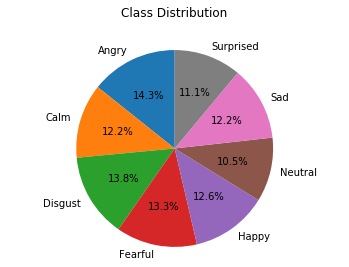

In [20]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [21]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
                     padding='same', input_shape=input_shape)) # 16 filters, 3x3 convolution(why square convolutions instead of rectangular?),  
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
                     padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), 
                     padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1), 
                     padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten()) # flatten to one dimension (why?)
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(classes), activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc']) #add loss here?
    return model
    

In [22]:
def get_recurrent_model():
    # Shape of data for RNN is (n, time(here: 9), features(here:13 because of numcep=13 when computing MFCC))
    # (n, time, feature)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, # The ouput of the LSTM can return a 1D or the actual sequences(then you need)
                   input_shape=input_shape)) #
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten()) # flatten to one dimension (why?)
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc']) #add loss here?
    return model
    

In [23]:
config = Config(mode='conv')
#config = Config(mode='time')

In [24]:
if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()

# For recurrent network
elif config.mode == 'time':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()

Loading existing data for conv model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 13, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 13, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 39, 13, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 39, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 6, 128)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 6, 128)        0         
_

In [25]:
X.shape

(26723, 39, 13, 1)

In [26]:
# May help accuracy/loss a couple percent if class distribution is uneven
class_weight = compute_class_weight('balanced',
                                    np.unique(y_flat),
                                    y_flat) # to compensate for classes that have fewer samples to train on

checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode='max', # val_acc -> mode='max', loss mode='minimum'
                             save_best_only=True, save_weights_only=False, period=1)

history = model.fit(X, y, epochs=50, batch_size=32,
         shuffle=True, # technically already shuffled(?)
         class_weight=class_weight, # to handle class imbalance, to make sure model doesn't create biases based on distribution of data size
         validation_split=0.2, callbacks=[checkpoint])

#model.save(config.model_path)


Train on 21378 samples, validate on 5345 samples
Epoch 1/50
21378/21378 [==============================] - 9s 401us/step - loss: 1.9062 - acc: 0.2417 - val_loss: 1.7387 - val_acc: 0.3280

Epoch 00001: val_acc improved from -inf to 0.32797, saving model to Processed/RAVDESSspeech/conv.model
Epoch 2/50
21378/21378 [==============================] - 4s 196us/step - loss: 1.6710 - acc: 0.3525 - val_loss: 1.5799 - val_acc: 0.3906

Epoch 00002: val_acc improved from 0.32797 to 0.39065, saving model to Processed/RAVDESSspeech/conv.model
Epoch 3/50
21378/21378 [==============================] - 4s 196us/step - loss: 1.5243 - acc: 0.4150 - val_loss: 1.4781 - val_acc: 0.4309

Epoch 00003: val_acc improved from 0.39065 to 0.43087, saving model to Processed/RAVDESSspeech/conv.model
Epoch 4/50
21378/21378 [==============================] - 4s 197us/step - loss: 1.4040 - acc: 0.4715 - val_loss: 1.3785 - val_acc: 0.4862

Epoch 00004: val_acc improved from 0.43087 to 0.48625, saving model to Processe

21378/21378 [==============================] - 4s 180us/step - loss: 0.2951 - acc: 0.8945 - val_loss: 1.0864 - val_acc: 0.7205

Epoch 00036: val_acc did not improve from 0.72479
Epoch 37/50
21378/21378 [==============================] - 4s 179us/step - loss: 0.3013 - acc: 0.8968 - val_loss: 1.0807 - val_acc: 0.7181

Epoch 00037: val_acc did not improve from 0.72479
Epoch 38/50
21378/21378 [==============================] - 4s 179us/step - loss: 0.2861 - acc: 0.8986 - val_loss: 1.1034 - val_acc: 0.7231

Epoch 00038: val_acc did not improve from 0.72479
Epoch 39/50
21378/21378 [==============================] - 4s 179us/step - loss: 0.2803 - acc: 0.9011 - val_loss: 1.0784 - val_acc: 0.7192

Epoch 00039: val_acc did not improve from 0.72479
Epoch 40/50
21378/21378 [==============================] - 4s 179us/step - loss: 0.2772 - acc: 0.9045 - val_loss: 1.0604 - val_acc: 0.7272

Epoch 00040: val_acc improved from 0.72479 to 0.72722, saving model to Processed/RAVDESSspeech/conv.model
Epoch 

In [27]:
history.params

{'batch_size': 32,
 'epochs': 50,
 'steps': None,
 'samples': 21378,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}

In [28]:
from sklearn.metrics import confusion_matrix

In [57]:
print(len(history.validation_data[1]))
print(history.validation_data[1])

5345
[[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]]


In [60]:
predictions_val = model.predict(history.validation_data[0])

In [65]:
predictions_val[0]

array([8.10617581e-04, 1.03800595e-07, 9.96807694e-01, 3.80794110e-04,
       4.77038084e-05, 1.05757111e-10, 9.38270299e-04, 1.01471250e-03],
      dtype=float32)

In [76]:
np.argmax(predictions_val, axis=1)

array([2, 0, 0, ..., 5, 7, 5])

In [77]:
np.argmax(history.validation_data[1], axis=1)

array([2, 0, 0, ..., 5, 7, 5])

In [68]:
history.validation_data[1]

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [79]:
conf_matrix = confusion_matrix(np.argmax(history.validation_data[1], axis=1), np.argmax(predictions_val, axis=1))
conf_matrix

array([[596,   1,  34,  29,  29,   6,   6,  32],
       [  8, 518,   9,   8,  16,  58,  23,   8],
       [ 61,  17, 519,  55,  34,  11,  29,  36],
       [ 51,   9,  15, 540,  45,   3,  20,  63],
       [ 35,  14,  13,  39, 498,   7,  12,  53],
       [  5,  19,   7,   5,  15, 488,  14,  15],
       [ 33,  43,  32,  56,  42,  34, 375,  26],
       [ 33,   6,  19,  44,  54,   6,  16, 398]])

In [93]:
len([np.argmax(history.validation_data[1], axis=1)[i] == np.argmax(predictions_val, axis=1)[i]  for i in range(0, len(history.validation_data[1]))])

5345

In [94]:
[np.argmax(history.validation_data[1], axis=1)[i] == np.argmax(predictions_val, axis=1)[i]  for i in range(0, len(history.validation_data[1]))].count(True)

3932

In [95]:
3932/5345

0.7356407857811038

In [91]:
print(np.argmax(history.validation_data[1], axis=1))

[2 0 0 ... 5 7 5]


In [92]:
np.argmax(predictions_val, axis=1)

array([2, 0, 0, ..., 5, 7, 5])

In [81]:
import seaborn as sn

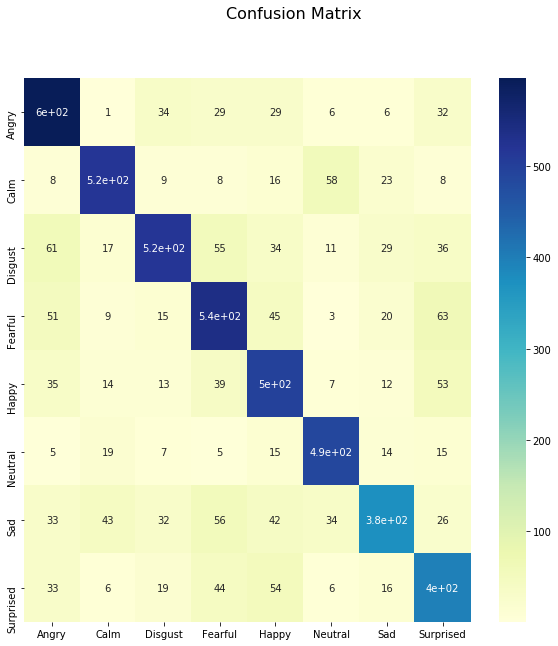

In [85]:
fig, axes = plt.subplots(figsize=(10,10))
df_cm = pd.DataFrame(conf_matrix, index=classes, columns=classes)
fig.suptitle('Confusion Matrix', size=16)
sn.heatmap(df_cm, annot=True, cmap='YlGnBu')

TESTING SHIT

In [ ]:
print(X.shape)
print(len(X[0]))
X[0][0]

In [ ]:
print(prereshape.shape)
print(len(prereshape[0]))
prereshape[0][0]

In [ ]:
prereshape.reshape(X.shape[0], X.shape[1], X.shape[2]).shape

PART 5 here